# IELTS Scored Essays

In this notebook I fine-tune a language model and use it to score a selection of IELTS essays.  
IELTS is a is a widely recognized international language proficiency test used to assess language skills and proficiency for academic and general purposes.  
[More information on the dataset can be found on Kaggle.](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data)

The model  
BigBird, is a sparse-attention based transformer which extends Transformer based models, such as BERT to much longer sequences. Moreover, BigBird comes along with a theoretical understanding of the capabilities of a complete transformer that the sparse model can handle.
4,096 tokens equates to approximately 11 pages of text, given standard document formatting and average word lengths. 

### Install and load dependencies

In [2]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    loralib==0.1.1 --quiet

%pip install matplotlib --quiet

!pip install sentencepiece

!pip install protobuf==3.20 # Downgrade the protobuf package:

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BigBirdForSequenceClassification, BigBirdConfig, AdamW
from sklearn.metrics import mean_squared_error

### Load and preprocess the data

In [ ]:
df = pd.read_csv("ielts_writing_dataset.csv")
print(f"There are {len(df)} essays in the dataset")

In [ ]:
df.head()

In [ ]:
df.count()
# The intermediate columns have no entries.


In [ ]:
# Drop the columns you don't need
columns_to_drop = ['Task_Type',
                   'Examiner_Commen',
                  'Task_Response',
                  'Coherence_Cohesion',
                 'Lexical_Resource',
                 'Range_Accuracy']

df.drop(columns_to_drop, axis=1,inplace=True)

In [ ]:
df.head()

In [ ]:
# Combine the Question and Essay columns
df['Combined'] = 'Question: ' + df['Question'] + '\n\n' + 'Essay: ' + df['Essay']

# Delete the original Question and Essay columns
df.drop(['Question', 'Essay'], axis=1, inplace=True)

# Swap the position of the Combined and Overall columns
df = df[['Combined','Overall', ]]

# Print the first few rows of the DataFrame
df.head()


In [ ]:
# Check one example
print(df["Combined"][0])

#### Save the df as csv

In [ ]:
df.to_csv('ielt_essays.csv')

### Define a DataSet Class

This code defines a PyTorch Dataset class for a dataset of essays and their grades. The class has two constructor arguments, `essays` and `grades`, which are lists of the essays and grades, respectively. The class also has a tokenizer, which is an instance of the `BertTokenizer` class from the `transformers` library.

The `__len__` method of the class returns the length of the dataset.  
The `__getitem__` method takes an index as an argument and returns a dictionary of tokenized tokens and a tensor of the grade for the essay at that index. The tokenization is done using the `BertTokenizer` class, with truncation and padding to a maximum length of 512 tokens.

Here is a more detailed explanation of the code:

* The `__init__` method first initializes the `essays` and `grades` attributes to the values passed to the constructor. It then initializes the `tokenizer` attribute to an instance of the `BertTokenizer` class, passing the `model_name` argument to the constructor.
* The `__len__` method simply returns the length of the `essays` list.
* The `__getitem__` method first gets the essay and grade at the specified index from the `essays` and `grades` lists, respectively. It then uses the `tokenizer` to tokenize the essay, with truncation and padding to a maximum length of 512 tokens. The tokenized tokens are returned in a dictionary, with the keys being the token names and the values being the token indices. The grade for the essay is also returned as a tensor.

The max_length-token limit is based on constraints related to memory and computational resources. Processing longer sequences requires exponentially more memory and computational power due to the nature of self-attention mechanisms in these models. As such, a limit is set to ensure the model can be trained and used effectively on available hardware.

In [16]:
model_name = 'google/bigbird-roberta-base'

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, essays, grades):
        self.essays = essays
        self.grades = grades
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        essay = self.essays[idx]
        grade = self.grades[idx]
        tokens = self.tokenizer(essay, truncation=True, padding='max_length', max_length=1024)
        return {key: torch.tensor(val, dtype=torch.long) for key, val in tokens.items()}, torch.tensor(grade, dtype=torch.float)


#### Load the data as a huggingface dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='ielt_essays.csv')
print(dataset)

Found cached dataset csv (/root/.cache/huggingface/datasets/csv/default-60a3f8ef85fec4c6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Combined', 'Overall'],
        num_rows: 1435
    })
})


#### Extract the essays and the grades

In [17]:
essays = dataset['train']['Combined'] # list of essay strings
grades = dataset['train']['Overall'] # list of numerical grades

#### Split the data

In [18]:
from sklearn.model_selection import train_test_split

# Split into training and temporary sets (80/20 split)
essays_train, essays_temp, grades_train, grades_temp = train_test_split(
    essays, grades, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50/50 split)
essays_val, essays_test, grades_val, grades_test = train_test_split(
    essays_temp, grades_temp, test_size=0.5, random_state=42)


#### Scale the grades  
QuantileTransformer: This scaler transforms the features to follow a uniform or a normal distribution.  
Therefore, for a given feature, this transformation tends to spread out the most frequent values and reduces the impact of (marginal) outliers.

In [19]:
from sklearn.preprocessing import QuantileTransformer

# Convert grades_train, grades_val, and grades_test lists to numpy arrays
grades_train = np.array(grades_train).reshape(-1,1)
grades_val = np.array(grades_val).reshape(-1,1)
grades_test = np.array(grades_test).reshape(-1,1)

# Apply the Quantile Transformer
quantile_transformer = QuantileTransformer(output_distribution='normal')
grades_train_scaled = quantile_transformer.fit_transform(grades_train)
grades_val_scaled = quantile_transformer.fit_transform(grades_val)
grades_test_scaled = quantile_transformer.fit_transform(grades_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (144). n_quantiles is set to n_samples.
  warnings.warn(


#### Tokenize the data  
Create a dataset where each item is a tuple containing the tokenized essay and the corresponding numerical grade.  
These datasets can then be used to create DataLoaders which will handle batching of data for training.

In [20]:
train_dataset = EssayDataset(essays_train, grades_train_scaled)
val_dataset = EssayDataset(essays_val, grades_val_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#### Initialize the original model 

In [21]:
original_model = BigBirdForSequenceClassification.from_pretrained(model_name, num_labels=1)  # For regression

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

#### Print the number of trainable model parameters

In [22]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 128060161
all model parameters: 128060161
percentage of trainable model parameters: 100.00%


### Parameter efficient fine tuning

#### 6.1 - Setup the PEFT/LoRA model for Fine-Tuning

Performing full-finetuning can lead to catastrophic forgetting because it changes all parameters on the model. Since PEFT only updates a small subset of parameters, it's more robust against this catastrophic forgetting effect.

Set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [23]:
%pip install peft==0.3.0 --quiet

from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    target_modules=["attention.self.query", "attention.self.value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS # Sequence classificatio task
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


#### Add LoRA adapter layers/parameters to the original LLM to be trained.


In [24]:
peft_model = get_peft_model(original_model, lora_config)

print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 2362370
all model parameters: 129831170
percentage of trainable model parameters: 1.82%


#### 6.3 - Train PEFT Adapter

This code is for fine-tuning a PEFT model on the IELTs essay dataset. It uses a learning rate of 1e-3 and a ReduceLROnPlateau scheduler with a patience of 3. The training and validation loops are implemented using the `process_batch()` function, which handles RuntimeErrors that occur when the TPU is out of memory. The model is saved to disk if the validation loss improves, and early stopping is implemented if the validation loss does not improve for 8 epochs.

Here is a detailed explanation of the code:

* The `n_epochs` variable specifies the number of epochs to train for.
* The `patience` variable specifies the number of epochs to wait after the last time the validation loss improved before early stopping is triggered.
* The `patience_counter` variable is used to track the number of epochs since the last time the validation loss improved.
* The `best_val_loss` variable stores the lowest validation loss that has been achieved so far.
* The `best_model` variable stores the weights of the model that achieved the best validation loss.
* The `optimizer` variable is an instance of the AdamW optimizer, which is used to optimize the PEFT model's parameters.
* The `scheduler` variable is an instance of the ReduceLROnPlateau scheduler, which is used to reduce the learning rate if the validation loss does not improve for a specified number of epochs.
* The `peft_model_path` variable specifies the path to the directory where the PEFT model and tokenizer will be saved.
* The `process_batch()` function handles RuntimeErrors that occur when the TPU is out of memory. It takes a batch of data, a PEFT model, and a boolean flag indicating whether the model is in training mode as input. If the model is in training mode, the gradients are zeroed and the loss is calculated. The loss is then backpropagated and the optimizer is used to update the model's parameters. If the model is not in training mode, the logits are calculated and returned.
* The `train_loss` variable is used to store the total loss for the training epoch.
* The `val_preds` and `val_labels` variables are used to store the predictions and labels for the validation set.
* The `val_mse` variable is used to store the mean squared error between the predictions and labels for the validation set.
* The `scheduler.step()` function is used to reduce the learning rate if the validation loss does not improve.
* The `patience_counter` variable is incremented if the validation loss does not improve.
* The `early stopping check` is triggered if the validation loss does not improve for 8 epochs. The training loop is then terminated.

In [ ]:
# With retry and learning rate scheduler

import time
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tenacity import retry, stop_after_attempt, wait_fixed

n_epochs = 20  # Make this a high number to benefit from early stopping
patience = 5  # How many epochs to wait after last time validation loss improved.
patience_counter = 0  # Counter for early stopping
best_val_loss = float('inf')
best_model = None

optimizer = AdamW(peft_model.parameters(), lr=1e-3)  # Use a higher learning rate than full fine tuning

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

peft_model_path =  './peft-essay-ielts-bigbird'

@retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
def process_batch(batch, model, is_training):
    """
    Retry decorator to handle RuntimeErrors that occur when the TPU is out of memory.

    Args:
        batch (tuple): A tuple containing the input tensors and labels for a single batch.
        model (torch.nn.Module): The PEFT model.
        is_training (bool): Whether the model is in training mode.

    Returns:
        loss (float): The loss for the batch.
        logits (list): The logits for the batch.
    """

    # If training, set the model to training mode and zero the gradients.
    if is_training:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    # Unpack and process the batch
    tokenized_tensors = batch[0]
    grades = batch[1]

    input_ids = tokenized_tensors['input_ids']
    attention_mask = tokenized_tensors['attention_mask']

    # Forward pass
    with torch.set_grad_enabled(is_training):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=grades if is_training else None)

    # If training, calculate the loss and perform backpropagation.
    if is_training:
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        return loss.item(), None
    else:
        return None, outputs.logits.squeeze().tolist()
    
start_time = time.time()  # Start time

# Training and Validation Loops
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(n_epochs):
    train_loss = 0
    val_preds, val_labels = [], []

    # Training loop
    for batch in train_dataloader:
        loss, _ = process_batch(batch, peft_model, True)
        train_loss += loss

    print(f'Epoch {epoch + 1}, Training loss: {train_loss / len(train_dataloader)}')

    # Validation loop
    with torch.no_grad():
        for batch in val_dataloader:
            _, logits = process_batch(batch, peft_model, False)
            val_preds.extend(logits)
            val_labels.extend(batch[1].tolist())

    val_mse = mean_squared_error(val_labels, val_preds)
    print(f'Validation MSE: {val_mse}')

    # Scheduler step
    scheduler.step(val_mse)

    # Check if validation loss improved
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        best_model = copy.deepcopy(peft_model.state_dict())
        patience_counter = 0
        print(f'Validation MSE improved to {val_mse}. Saving model!')
        
        # Save best model to disk
        # First ensure the best model weights are loaded
        peft_model.load_state_dict(best_model)

        # Save model weights
        peft_model.save_pretrained(peft_model_path)

        # Save tokenizer from the train_dataset
        train_dataset.tokenizer.save_pretrained(peft_model_path)
    else:
        patience_counter += 1
        print(f'Validation MSE did not improve. Patience: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Stopping early after {patience_counter} epochs without improvement.')
        break

end_time = time.time()  # End time
total_time = end_time - start_time  # Total training time in seconds

print(f"Total training time: {total_time // 60:.0f} minutes {total_time % 60:.0f} seconds")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 1.0372480524496899
Validation MSE: 2.289461273497354
Validation MSE improved to 2.289461273497354. Saving model!
Epoch 2, Training loss: 1.4541958248656657
Validation MSE: 0.9449602398515122
Validation MSE improved to 0.9449602398515122. Saving model!
Epoch 3, Training loss: 0.9987528264626033
Validation MSE: 1.1764783283873508
Validation MSE did not improve. Patience: 1/5
Epoch 4, Training loss: 0.7624725503329601
Validation MSE: 1.1107129676351983
Validation MSE did not improve. Patience: 2/5
Epoch 6, Training loss: 0.720506975116829
Validation MSE: 0.9837131440700191
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Validation MSE did not improve. Patience: 4/5
Epoch 8, Training loss: 0.3830901011048506
Validation MSE: 0.7779729928738243
Validation MSE improved to 0.7779729928738243. Saving model!
Epoch 9, Training loss: 0.3386776602516572
Validation MSE: 0.7075429963527182
Validation MSE improved to 0.7075429963527182. Saving model!
Epoch 10, Tra

#### Save the final best model and the corresponding tokenizer 

In [27]:
# Ensure the best model weights are loaded
peft_model.load_state_dict(best_model)

# Save model weights
peft_model.save_pretrained(peft_model_path)

# Save tokenizer from the train_dataset
train_dataset.tokenizer.save_pretrained(peft_model_path)


('./peft-essay-ielts-bigbird/tokenizer_config.json',
 './peft-essay-ielts-bigbird/special_tokens_map.json',
 './peft-essay-ielts-bigbird/spiece.model',
 './peft-essay-ielts-bigbird/added_tokens.json',
 './peft-essay-ielts-bigbird/tokenizer.json')

#### Optional: Reload model and tokenizer from file when needed

In [ ]:
peft_model = BigBirdForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

### Inference
#### Prepare this model by adding an adapter to the original model.
Set is_trainable=False because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set is_trainable=True.

In [28]:
from peft import PeftModel, PeftConfig

peft_model_base = BigBirdForSequenceClassification.from_pretrained(model_name, num_labels=1, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       peft_model_path, 
                                       torch_dtype=torch.bfloat16,
                                       num_labels=1,
                                       is_trainable=False)

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

#### Evaluate the performance on the test set

The code is used to evaluate the performance of a BERT-based model for essay scoring. The model is first trained on a dataset of essays and their corresponding grades. Then, the model is tested on a separate dataset of essays and their grades. The metrics used to evaluate the model's performance are mean squared error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE).

The code starts by importing the necessary libraries, including numpy, sklearn, and torch. It then defines a function to calculate mean absolute percentage error (MAPE).

The next step is to load the data. The data is stored in two lists: essays_test and grades_test. The essays_test list contains the essays that will be used to test the model, and the grades_test list contains the corresponding grades for each essay.

The code then loops through the essays_test list, one essay at a time. For each essay, the code creates a prompt that includes the essay text and a request for a score. The prompt is then passed to the tokenizer, which converts it into a sequence of tokens. The tokens are then passed to the model, which makes a prediction for the essay's grade. The prediction is then appended to the y_pred list.

The code also checks the length of the tokenized essay. If the length of the essay is greater than the maximum length allowed by the model, the code skips the essay and moves on to the next one.

Once all of the essays have been processed, the code calculates the MSE, MAE, and MAPE scores. The scores are then printed to the console.

Here is a more detailed explanation of the code:

* The `import` statements import the necessary libraries for the code to run.
* The `def mean_absolute_percentage_error()` function calculates MAPE.
* The `load_data()` function loads the data from the `essays_test` and `grades_test` lists.
* The `for` loop iterates through the essays_test list, one essay at a time.
* The `prompt` variable is created by concatenating the essay text and a request for a score.
* The `inputs` variable is created by passing the prompt to the tokenizer.
* The `input_length` variable is calculated by getting the size of the first dimension of the `inputs.input_ids` tensor.
* If the `input_length` is greater than the maximum length allowed by the model, the code skips the essay and moves on to the next one.
* The `device` variable is set to `cuda` if CUDA is available, otherwise it is set to `cpu`.
* The `inputs` variable is updated by moving the tensors to the same device as the model.
* The `original_model` and `peft_model` are set to evaluation mode.
* The `torch.no_grad()` context manager is used to disable gradient calculation for inference.
* The `peft_model_outputs` variable is created by passing the `inputs` to the `peft_model`.
* The `peft_model_score` variable is created by getting the value of the `logits` tensor from the `peft_model_outputs` variable.
* The `y_pred` list is updated by appending the `peft_model_score` value.
* The `y_test` list is updated by appending the corresponding grade value from the `grades_test` list.
* The `if` statement prints a progress message every nth iteration.
* The `y_pred_original` and `y_test_original` variables are created by scaling the grades back to their original values.
* The `mse`, `mae`, and `mape` variables are calculated by using the `mean_squared_error()`, `mean_absolute_error()`, and `mean_absolute_percentage_error()` functions.
* The `print()` statements print the MSE, MAE, and MAPE scores to the console.

MAPE
For regression tasks, the concept of an error percentage is not as straightforward as in classification tasks because the range of possible values is not bounded between 0 and 1. However, there are relative error metrics that can provide a sense of the error relative to the magnitude of the values being predicted. One such metric is the Mean Absolute Percentage Error (MAPE).

MAPE measures the size of the error in percentage terms. It is calculated as the average of the absolute percentage errors of the predictions.

MAPE has some drawbacks, though:

It can be undefined if any y true values are or close to zero.
It puts a heavier penalty on negative errors than positive ones in certain contexts.

In [84]:
# Predict the test set scores

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


n=10 # print progress every nth batch
y_test = []
y_pred = []
max_length = 4096  # Maximum length for BigBird model

start_time = time.time()

for index in range(len(essays_test)):
    
    essay = essays_test[index]
    scaled_score = grades_test_scaled[index]
    
    prompt = f"""
    Assign a score to the following essay.
    
    {essay}
    
    Score:
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Check the length of the tokenized essay
    input_length = inputs.input_ids.size(1)
    if input_length > max_length:
        print(f"Skipping essay {index} with length {input_length}...")
        continue
    
    # Move tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make sure your models are in evaluation mode
    original_model.eval()
    peft_model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get model predictions
        peft_model_outputs = peft_model(**inputs)
        peft_model_score = peft_model_outputs.logits.squeeze().item()

        y_pred.append(peft_model_score)
        y_test.append(scaled_score)
    
    # Print progress message every nth iteration
    if index % n == 0:
        print(f"Processing batch {index}/{len(essays_test)}")    
        
# Scale the grades back to their original values
y_pred_original = quantile_transformer.inverse_transform(np.array(y_pred).reshape(-1,1))
y_test_original = quantile_transformer.inverse_transform(np.array(y_test).reshape(-1,1))

# Calculate MSE, MAE, MAPE
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print("\n")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

end_time = time.time()  # End time
total_time = end_time - start_time  # Total training time in seconds

print(f"Total inference time: {total_time // 60:.0f} minutes {total_time % 60:.0f} seconds")

Processing batch 0/144
Processing batch 10/144
Processing batch 20/144
Processing batch 30/144
Processing batch 40/144
Processing batch 50/144
Processing batch 60/144
Processing batch 70/144
Processing batch 80/144
Processing batch 90/144
Processing batch 100/144
Processing batch 110/144
Processing batch 120/144
Processing batch 130/144
Processing batch 140/144


Mean Squared Error: 0.60
Mean Absolute Error: 0.57
Mean Absolute Percentage Error (MAPE): 9.26%
Total inference time: 0 minutes 28 seconds


#### Plot results  - with outlier identification

For outliers to be identified and plotted (in red), you first need to define what qualifies as an outlier in your data.  
A common approach is to use a threshold based on some metric, like the absolute difference between actual and predicted values.

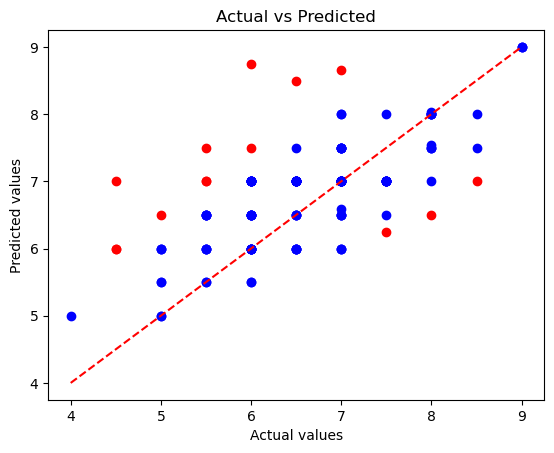

In [67]:
#Outliers

import matplotlib.pyplot as plt

# Example threshold for outliers
outlier_threshold = 1.25  # Absolute allowable difference between actual and poredicted values

# Plot each point, coloring outliers in red
for actual, predicted in zip(y_test_original, y_pred_original):
    color = 'red' if abs(actual - predicted) > outlier_threshold else 'blue'
    plt.scatter(actual, predicted, color=color)

# Add titles and labels
plt.title('Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Plot the reference line
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')

# Show the plot
plt.show()


#### Calculate the tolerance distribution of the scores.  
i.e. how many essays fall within a certtain tolerance of the actual score

In [81]:
total_essays = len(y_test_original)
tolerance_counts = {"5%": 0, "10%": 0, "15%": 0, "20%": 0, "25%+": 0}

for actual, predicted in zip(y_test_original, y_pred_original):
    percent_error = abs(actual - predicted) / actual

    if percent_error <= 0.05:
        tolerance_counts["5%"] += 1
    elif percent_error <= 0.10:
        tolerance_counts["10%"] += 1
    elif percent_error <= 0.15:
        tolerance_counts["15%"] += 1
    elif percent_error <= 0.20:
        tolerance_counts["20%"] += 1
    elif percent_error > 0.25:
        tolerance_counts["25%+"] += 1

# Calculate cumulative percentage
cumulative_count = 0
print("Tolerance Level | Number of Essays | % of Total Essays | Cumulative %")
print("-------------------------------------------------------------------------")
for tolerance, count in tolerance_counts.items():
    cumulative_count += count
    cumulative_percentage = (cumulative_count / total_essays) * 100
    percentage = (count / total_essays) * 100
    print(f"{tolerance:>14} | {count:>16} | {percentage:>17.0f}% | {cumulative_percentage:>13.0f}%")


Tolerance Level | Number of Essays | % of Total Essays | Cumulative %
-------------------------------------------------------------------------
            5% |               43 |                30% |            30%
           10% |               59 |                41% |            71%
           15% |                8 |                 6% |            76%
           20% |               22 |                15% |            92%
          25%+ |                9 |                 6% |            98%


#### Pull out the outliers for human evaluation

In [69]:
outliers = []

for index, (actual, predicted) in enumerate(zip(y_test_original, y_pred_original)):
    if abs(actual - predicted) > outlier_threshold:
        outlier_info = {
            'essay': essays_test[index],
            'actual_grade': actual.item(),
            'predicted_grade': round(predicted.item(),1)
        }
        outliers.append(outlier_info)

# Convert outliers list to JSON format
outliers_json = json.dumps(outliers, indent=4)
print(f"There are {len(outliers)} outliers out of {len(essays_test)} essays.")
print(f"Here are the {len(outliers)} outlier essays. You may want to evaluate these yourself.\n")
print("OUTLIER ESSAYS")
print(outliers_json)

There are 14 outliers out of 144 essays.
Here are the 14 outlier essays. You may want to evaluate these yourself.

OUTLIER ESSAYS
[
    {
        "essay": "Question: The bar chart below shows the number of houses built per year in two cities, Derby and Nottingham, Between 2000 and 2009. Write a report for a university lecturer describing the information shown below.You should write at least 150 words.\n\nEssay: The bar chart gives information regarding the number of houses annually built in two cities, Derby and Nottingham, between 2000 to 2009. Overall, more houses have been constructed in Derby during the given time.\nIn 2000 and 2001, around 50 houses have been created in Nottingham. After, the number of new buildings decreased massively to less than 20. From 2003 to 2005, around 50 or more houses have been built. Later, the civil construction sector experienced a massive decline to less than 10 by 2006, before jumping to over 150. In 2008 the next dramatically fall happened again, 

#### GPT4 Comparison